In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from util import engineer_features, prep_X_y

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_df = engineer_features(sorted_dyads_df)

df_train = cleaned_dyads_df[cleaned_dyads_df["Arm_Sham"]]
# df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=False)
df_test = cleaned_dyads_df[~cleaned_dyads_df["Arm_Sham"]]

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_37353/3038958328.py:9: DtypeWarning: Columns (93,122,123,124,125,126) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
/Users/zhu.henian/projects/pistachio/util.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


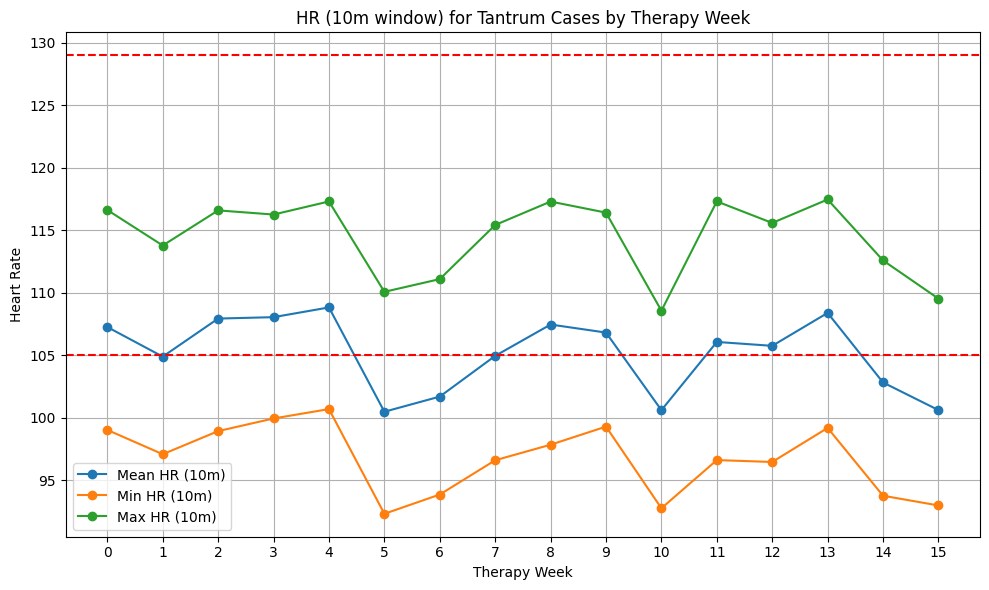

In [14]:
import matplotlib.pyplot as plt

weeks = (0, 15)
window = "60m"


# Filter for cases with tantrum within 15m and therapy_week in 0-10
df_all = pd.concat([df_train, df_test])
weeks_range = range(weeks[0], weeks[1] + 1)
mask = (df_all["tantrum_within_60m"]) & ((df_all["therapy_week"]).between(*weeks))
df_cases = df_all[mask]


means = []
mins = []
maxs = []

for week in weeks_range:
    week_data = df_cases[df_cases["therapy_week"] == week]
    means.append(week_data["hr_moving_avg_10m"].mean())
    mins.append(week_data["hr_moving_min_10m"].mean())
    maxs.append(week_data["hr_moving_max_10m"].mean())

plt.figure(figsize=(10, 6))
plt.plot(weeks_range, means, marker="o", label="Mean HR (10m)")
plt.plot(weeks_range, mins, marker="o", label="Min HR (10m)")
plt.plot(weeks_range, maxs, marker="o", label="Max HR (10m)")
plt.axhline(105, color="red", linestyle="--")
plt.axhline(129, color="red", linestyle="--")
plt.legend()
plt.xlabel("Therapy Week")
plt.ylabel("Heart Rate")
plt.title("HR (10m window) for Tantrum Cases by Therapy Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(weeks_range)
plt.show()

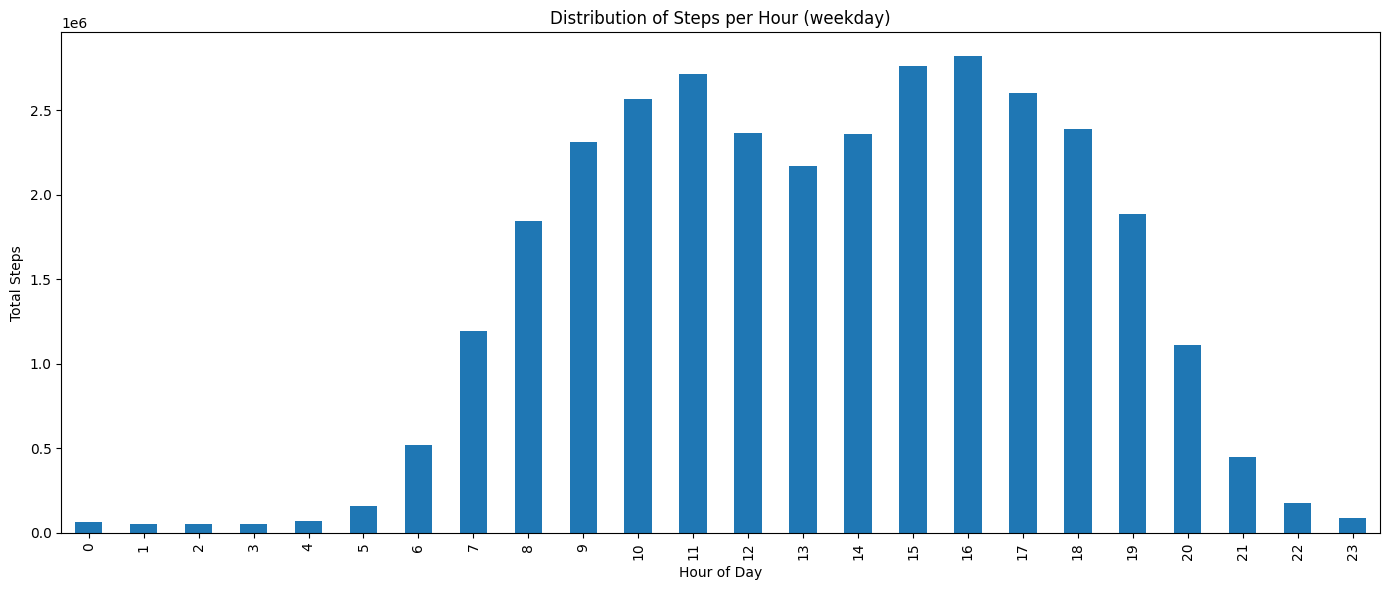

In [3]:
import matplotlib.pyplot as plt

# Group by date and sum steps per day
steps_per_hour = df_all.groupby(df_all["ActivityDateTime"].dt.hour)["Steps_15m"].sum()

plt.figure(figsize=(14, 6))
steps_per_hour.plot(kind="bar")
plt.xlabel("Hour of Day")
plt.ylabel("Total Steps")
plt.title("Distribution of Steps per Hour (weekday)")
plt.tight_layout()
plt.show()

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_37353/2009973602.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_37353/2009973602.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


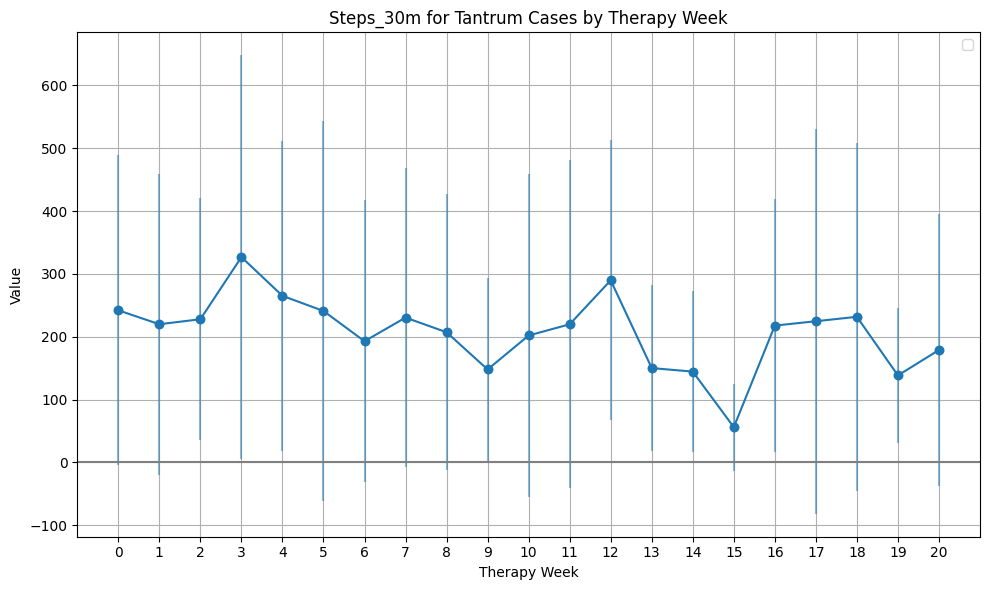

In [12]:
import matplotlib.pyplot as plt

weeks = (0, 20)
window = "60m"
feature = "Steps_30m"


# Filter for cases with tantrum within 15m and therapy_week in 0-10
df_all = pd.concat([df_train, df_test])
weeks_range = range(weeks[0], weeks[1] + 1)
mask = (df_all["tantrum_within_60m"]) & ((df_all["therapy_week"]).between(*weeks))
df_cases = df_all[mask]


values = []
stds = []

for week in weeks_range:
    week_data = df_cases[(df_cases["therapy_length_days"] // 7) == week]
    values.append(week_data[feature].mean())
    stds.append(week_data[feature].std())

plt.figure(figsize=(10, 6))
plt.plot(weeks_range, values, marker="o")
plt.errorbar(
    weeks_range,
    values,
    yerr=stds,
    fmt="o",
    color="tab:blue",
    alpha=0.5,
)

plt.legend()
plt.xlabel("Therapy Week")
plt.ylabel("Value")
plt.title(f"{feature} for Tantrum Cases by Therapy Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.axhline(0, color="gray")
plt.xticks(weeks_range)
plt.show()